In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
# HOG & Extraction
from skimage.feature import hog
import time
import matplotlib.image as mpimg
#SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
import pickle
import warnings
from scipy.ndimage import label
import random
from moviepy.editor import VideoFileClip


Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2768896/45929032 bytes (6.0%)5996544/45929032 bytes (13.1%)8839168/45929032 bytes (19.2%)11534336/45929032 bytes (25.1%)14671872/45929032 bytes (31.9%)17883136/45929032 bytes (38.9%)20791296/45929032 bytes (45.3%)23830528/45929032 bytes (51.9%)26771456/45929032 bytes (58.3%)29745152/45929032 bytes (64.8%)32899072/45929032 bytes (71.6%)35815424/45929032 bytes (78.0%)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Loading dataset

In [5]:
cars_dir = [car for car in glob.glob("../dataset/vehicles/*/*.png",recursive=True)]
non_car_dir = [non_car for non_car in glob.glob("../dataset/non-vehicles/*/*.png",recursive=True)]
print("Cars loaded: {} Non cars loaded: {}".format(len(cars_dir),len(non_car_dir)))

Cars loaded: 0 Non cars loaded: 0


#### Loading test Images

In [6]:
def display_images(images,rows,columns,text=[],axis="off"):
    fig = plt.figure(figsize=(30, 30))
    for i in enumerate(images):
        # Adds a subplot at the 1st position
        fig.add_subplot(rows, columns, i[0]+1)
        # showing image
        plt.imshow(i[1])
        plt.axis(axis)
        try:
            plt.title(text[i[0]])
        except:
            if(i[0]==0):
                print("No text input")
    pass

In [7]:
test_images = [plt.imread(i) for i in glob.glob("/content/drive/MyDrive/Image Processing Phase 2/test_images/*.jpg")]

display_images(test_images,len(test_images)//2,2,axis="on")

Output hidden; open in https://colab.research.google.com to view.

## HOG

#### Feature Extraction 

In [8]:
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
#     print(features.shape)
    return features

def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
#     Seems like a useless step each channel for all images return same result
#     plt.hist(channel1_hist,bins=32,range=(0,256))
#     plt.hist(channel2_hist,bins=32,range=(0,256))
#     plt.hist(channel3_hist,bins=32,range=(0,256))
#     print(hist_features.shape)
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Return HOG features and visualization
# Hog takes only gray images
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualize=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualize=vis, feature_vector=feature_vec)
        return features
def convert_rgb_color(img, conv='YCrCb'):
    if conv == 'RGB':
        return np.copy(img)
    if conv == 'YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if conv == 'HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if conv == 'LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    
# Extract feature wrapper that extracts and combines all features
def extract_features(imgs,params):
    cspace= params['color_space']
    hog_channel=params['hog_channel']
    orient=params['orient']
    pix_per_cell= params['pix_per_cell']
    cell_per_block=params['cell_per_block']
    spatial_size=params['spatial_size']
    hist_bins=params['hist_bins']
    hist_range=params['hist_range']
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB' 
        feature_image = convert_rgb_color(image,cspace)
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features) #Join all channels hog features into one feature vector        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range) # Seems useless (?)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features,hog_features))) # Add all features into one feature vector
        
    # Return list of feature vectors
    return features

In [9]:
## Parameters
params={}
params['color_space'] ='YCrCb'
params['hog_channel'] ='ALL'
params['orient'] = 9
params['pix_per_cell'] = 8
params['cell_per_block'] = 2
params['spatial_size'] = (32,32)
params['hist_bins'] = 32 
params['hist_range'] = (0,256)

## SVM 

#### Extracting features

In [ ]:
t1=time.time()

cars_features = extract_features(cars_dir,params)
notcars_features = extract_features(non_car_dir,params) 

t2 = time.time()
print(round(t2-t1, 2), 'second to extract features (HOG,spatial and color features).')

#### Data Standardization Step

In [ ]:
#Making one feature vector that starts with cars and ends with non_cars
X = np.vstack((cars_features, notcars_features)).astype(np.float64)
#Computes the mean and standard deviation to be used for later scaling.
X_scaler = StandardScaler().fit(X)  #z = (x - u) / s

# Apply the scaler to X
scaled_X = X_scaler.transform(X) #Perform standardization by centering and scaling.

# scaled_X = StandardScaler().fit_transform(X) #  Does both steps at once
# Labeling feature vector <Cars = 1> <Not Cars = 0>
y = np.hstack((np.ones(len(cars_dir)), np.zeros(len(non_car_dir))))

#### Data Split train & test

In [ ]:
rand_state = np.random.randint(0, 100) # Store state and also generate random test-train splits
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)
print('Number of samples in train set: ', len(X_train))
print('Number of samples in test set: ', len(X_test))

In [ ]:
print('Feature vector length:', len(X_train[0]))
svc = LinearSVC()
#Training SVC
t1 = time.time()
svc.fit(X_train, y_train)
print(time.time()-t1,'Seconds to train SVC...')
# Find accuracy using test set
print('SVC Accuracy = {:.4}'.format(svc.score(X_test, y_test)))
# Check the prediction time for 100 samples
t=time.time()
n_predict = 100
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

#### Save to pickle file step

In [ ]:
dist_pickle = {}
dist_pickle["svc"] = svc
dist_pickle["scaler"] = X_scaler
pickle.dump(dist_pickle, open("classifier.p", 'wb') )
print('Classifier saved to a pickle file')

## Car Detection

#### Car Detection Function

In [13]:
def detect_cars(img,params, h_shift=0, visualization=False):
     #Parameters:
    svc=params['svc']
    X_scaler=params['scaler']
    orient=params['orient']
    cells_per_step = params['cells_per_step']
    pix_per_cell=params['pix_per_cell']
    cell_per_block=params['cell_per_block']
    spatial_size=params['spatial_size']
    hist_bins=params['hist_bins']
    ystart_ystop_scale = params['ystart_ystop_scale']
    
    #Boxes
    detected_boxes_list = [] # All detected cars in an image
    window_visited_list = [] # All windows in an image
    
    #to make computation efficient by reducing values between 0 to 1
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    #Searching at different window sizes to get as much detection
    for (ystart, ystop, scale) in ystart_ystop_scale:
        
        #Crop region of interest:
        #Far of the camera should have smaller window scale, closer should have bigger window scale.
        
        search_img = img[ystart:ystop, :, :]
        conv_color_img = cv2.cvtColor(search_img, cv2.COLOR_RGB2YCrCb)
        
        
        if scale != 1:
            imshape = conv_color_img.shape
            conv_color_img = cv2.resize(conv_color_img, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
        ch1 = conv_color_img[:,:,0]
        ch2 = conv_color_img[:,:,1]
        ch3 = conv_color_img[:,:,2]
        
        # Define number of blocks:
        nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 3  # All possible x blocks
        nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 # All possible y blocks
        nfeat_per_block = orient*cell_per_block**2 # Just a measurement of number of features
        
        # Window size is 64x64
        window = 64
        #Number of blocks per window
        nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1# can also mean no of cells / window
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step
        #nxsteps * nysteps = number of windows I think
        #print("nxsteps:",nxsteps,"nysteps:",nysteps, "number of windows:",nxsteps*(nysteps))
        
        # Compute individual channel HOG features for the entire image
        # This is an optimization much better than getting hog for each single window
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
        
        # Sliding Window
        box_vis=[]
        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                # Extract HOG for this patch
                # Hog cells in x , y
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
                
                # Position of window in pixels in the scaled cropped image
                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell
                
                # Extract the image patch covered by current window
                subimg = cv2.resize(conv_color_img[ytop:ytop+window, xleft:xleft+window], (window,window))
                
                # Get color features
                spatial_features = bin_spatial(subimg, size=spatial_size)
                hist_features = color_hist(subimg, nbins=hist_bins)
                
                # Scale features and make a prediction
                test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
                
                # Make prediction based on trained model 
                test_prediction = svc.predict(test_features) # Returns 1 if car is detected 0 if not
                
                if(visualization): # Draw a box over the real image
                    # To view scale and compare it to car sizes
                    xbox_left = np.int(xleft*scale) 
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    # Append Detection Position to list 
                    box_vis.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                # Detected cars go here
                if test_prediction == 1:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    # Append Detection Position to list 
                    detected_boxes_list.append(((xbox_left+h_shift, ytop_draw+ystart),(xbox_left+win_draw+h_shift,ytop_draw+win_draw+ystart)))

        window_visited_list += [box_vis]
    if(visualization):
        return detected_boxes_list, window_visited_list
    return detected_boxes_list
        
        
            

    
    

#### Load classifer

In [14]:
dist_pickle = {}
dist_pickle = pickle.load( open("/content/drive/MyDrive/Image Processing Phase 2/classifier.p", "rb" ) )


In [15]:
## Redefining parameters
params['svc'] = dist_pickle['svc']
params['scaler'] = dist_pickle['scaler']
params['color_space'] ='YCrCb'
params['hog_channel'] ='ALL'
params['orient'] = 9
params['pix_per_cell'] = 8
params['cell_per_block'] = 2
params['cells_per_step'] = 2
params['spatial_size'] = (32,32)
params['hist_bins'] = 32 
params['hist_range'] = (0,256)
params['ystart_ystop_scale'] = [(405, 510, 1),(400, 600, 1.5), (500, 710, 2) ] 

In [16]:
def draw_boxes(img, bboxes, thickness=2):
    imcopy = [np.copy(img),np.copy(img),np.copy(img)]
    for i in range(len(bboxes)):
        for bbox in bboxes[i]:
            r = random.randint(0,255)
            g = random.randint(0,255)
            b = random.randint(0,255)
            color = (r,g,b)
            cv2.rectangle(img=imcopy[i], pt1=bbox[0], pt2=bbox[1],
                          color=color, thickness=thickness)
    return imcopy

#### Visualize Window Size At Different Positions

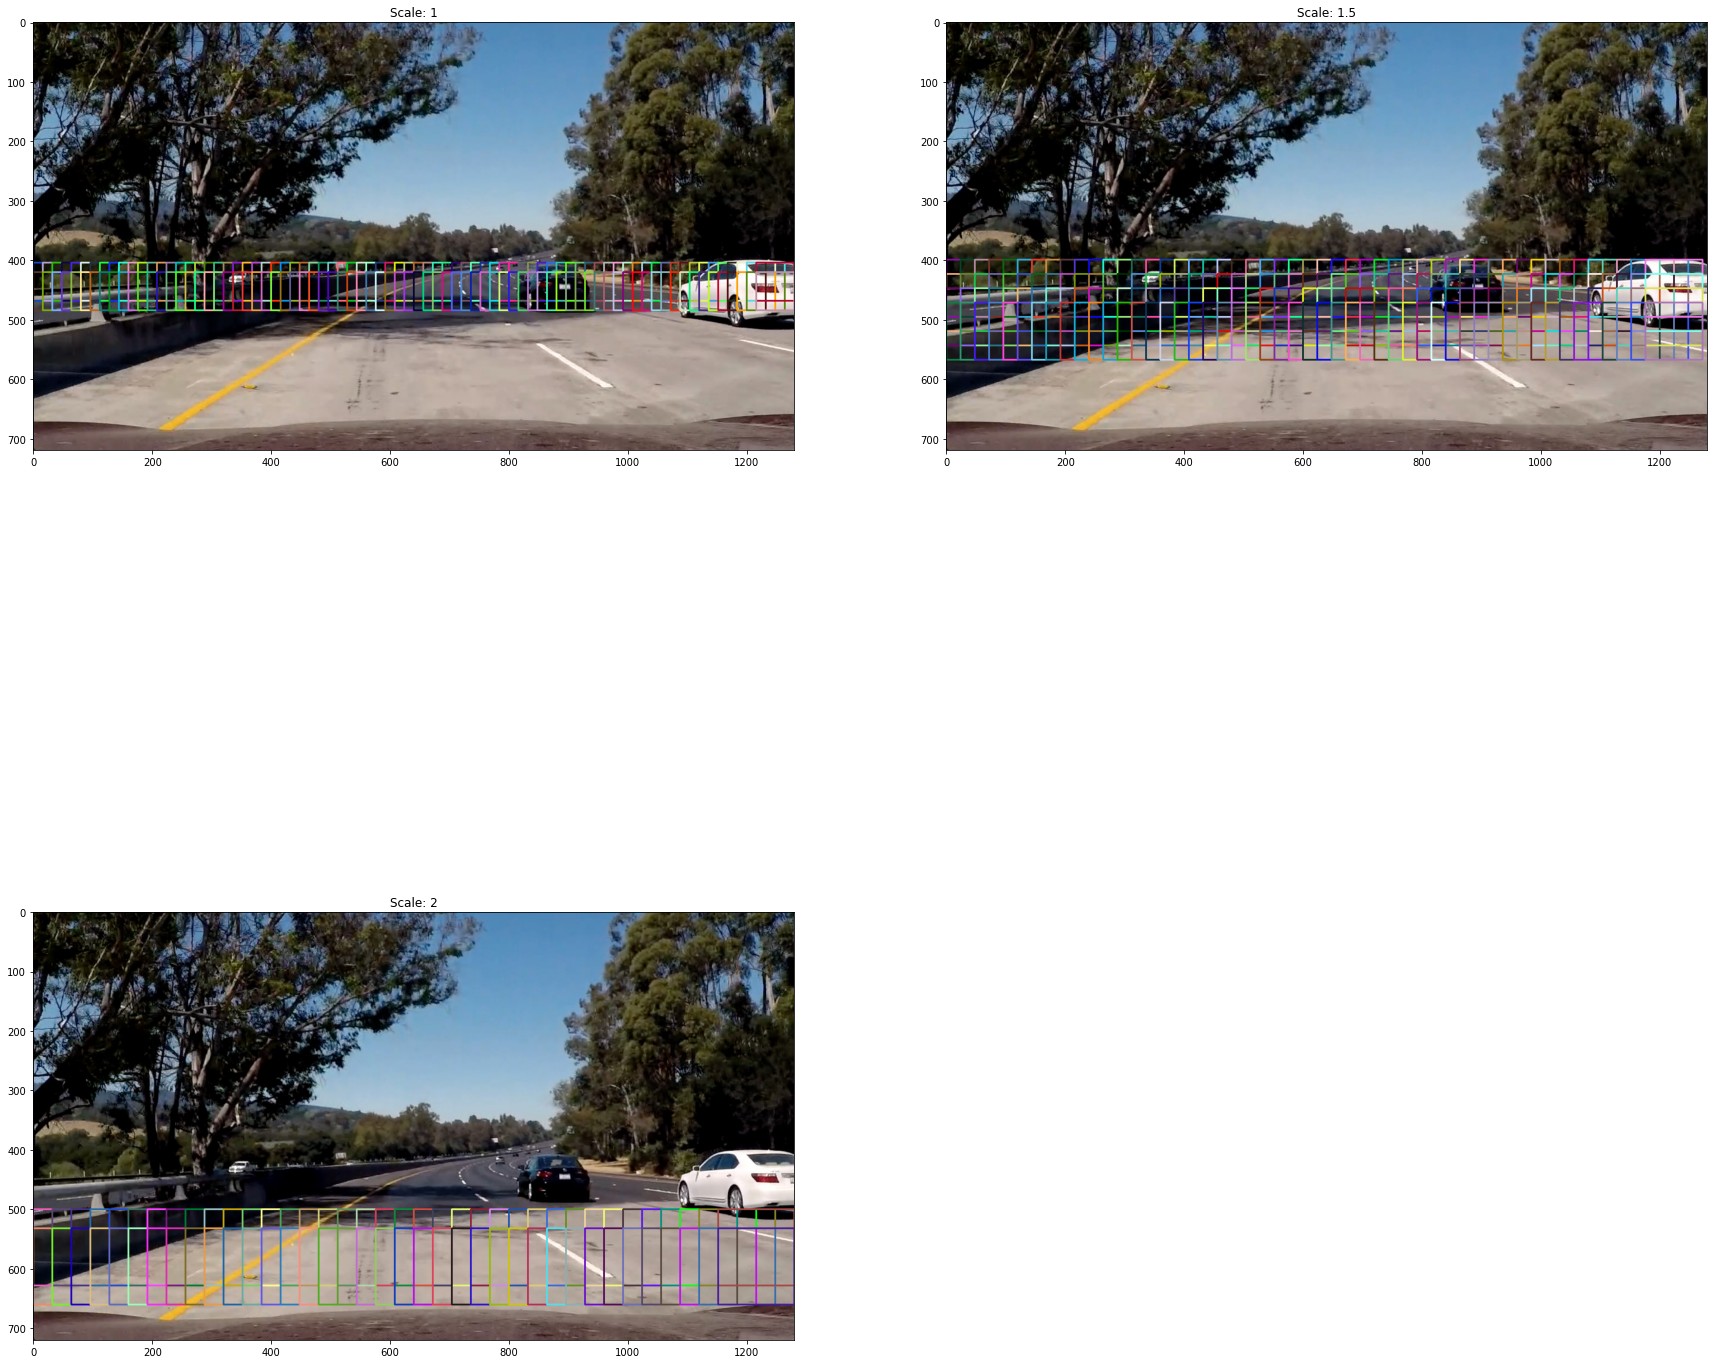

In [17]:
warnings.filterwarnings("ignore",category=DeprecationWarning)
detection_img = test_images[7]
detected,visited = detect_cars(detection_img,params,visualization = True)
window_capture = draw_boxes(detection_img, visited)
display_images(window_capture,len(window_capture)//2+1,2,text=["Scale: 1","Scale: 1.5", "Scale: 2"],axis="on")

#### Draw Detected Cars

In [18]:
def detected_boxes(img, dboxes, thickness=2):
    imcopy = np.copy(img)
    for dbox in dboxes:
        r = random.randint(0,255)
        g = random.randint(0,255)
        b = random.randint(0,255)
        color = (r,g,b)
        cv2.rectangle(img=imcopy, pt1=dbox[0], pt2=dbox[1],
                      color=color, thickness=thickness)
    return imcopy

In [19]:
boxes_detected = [detect_cars(detection_img, params) for detection_img in test_images]
window_capture = [detected_boxes(test_images[i],boxes_detected[i]) for i in range(len(boxes_detected))]
display_images(window_capture,len(window_capture)//2+1,2,axis="on")
# We seem to have a problem of false positives and multiple boxes 
# Solution is thresholding using heatmap

Output hidden; open in https://colab.research.google.com to view.

#### Heatmap 

In [20]:
def add_heat(heatmap, boxes):
    # Iterate through list of bboxes
    img = np.copy(heatmap)
    for box in boxes:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        img[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return img# Iterate through list of bboxes

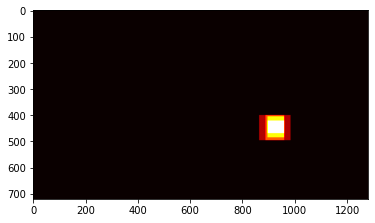

In [21]:
heatmap2 = np.zeros_like(test_images[3][:,:,0]).astype(np.float) # grey scale of same size as image
heatmap2 = add_heat(heatmap2,boxes_detected[3])
plt.imshow(heatmap2,cmap='hot')

In [22]:
# Removes false-postivies
def apply_threshold(heatmap, threshold):
    # create a copy to exclude modification of input heatmap
    heatmap = np.copy(heatmap)
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    heatmap = np.clip(heatmap, 0, 255)
    # Return thresholded map
    return heatmap

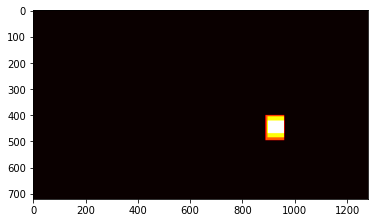

In [23]:
heatmap = apply_threshold(heatmap2,1)
plt.imshow(heatmap,cmap='hot')

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)


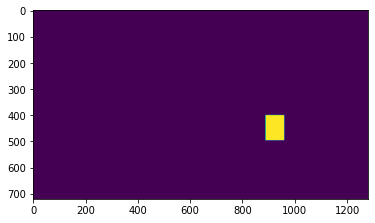

In [24]:
# use label to group boxes surrounding object into one box
labels = label(heatmap)
print(labels) 
# labels[0] groups close objects into similar group and are given similar number
# labels[1] is how many groups are there
plt.imshow(labels[0])

In [25]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    imgcopy = np.copy(img)
#     r = random.randint(0,255)
#     g = random.randint(0,255)
#     b = random.randint(0,255)
    color = (255,20,147)
    for car_number in range(1, labels[1]+1): #car_number gets the value of pixel crossponding to the object
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero() #returns rows and columns of nonzero pixels
        # Identify x and y values of those pixels  
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy))) # Diagonal of a rectangle
        # Draw the box on the image

        cv2.rectangle(imgcopy, bbox[0], (bbox[1][0]+10,bbox[1][1]-10), color, 2)
        cv2.putText(imgcopy,"Car",(bbox[0][0],bbox[0][1]-5),cv2.FONT_HERSHEY_SIMPLEX,0.5,color,2)
    # Return the image
    return imgcopy

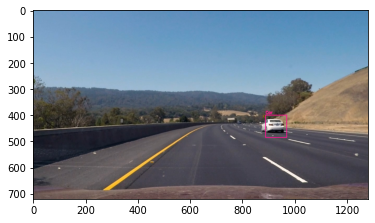

In [26]:
final_image = draw_labeled_bboxes(test_images[3],labels)
plt.imshow(final_image)

#### Video pipeline

In [27]:
## Redefining parameters
params['svc'] = dist_pickle['svc']
params['scaler'] = dist_pickle['scaler']
params['color_space'] ='YCrCb'
params['hog_channel'] ='ALL'
params['orient'] = 9
params['pix_per_cell'] = 8
params['cell_per_block'] = 2
params['cells_per_step'] = 2
params['spatial_size'] = (32,32)
params['hist_bins'] = 32
params['heat_threshold'] = 1
params['hist_range'] = (0,256)
params['ystart_ystop_scale'] = [(405, 510, 1),(400, 600, 1.5), (500, 710, 2.5) ] 

In [32]:
# Smoother detection
class PrevDetection():
    def __init__ (self):
        # Number labels to store
        self.stored_frames = []
        self.number_of_frames = 7 # Max number of frames to store

    # Put new frame
    def add_frame(self, detection):
        if (len(self.stored_frames) > self.number_of_frames): # pop oldest frame from the array of previous detections if array is full
            tmp = self.stored_frames.pop(0)
        self.stored_frames.append(detection) # add new frame to the array
    
    # Get last N frames
    def get_detections(self):
        detections = []
        for detection in self.stored_frames:
            detections.extend(detection) # add all previously detected frames into one array
        return detections

In [33]:
prev_detections = PrevDetection()

In [34]:
def process_image(img): 
    heat_threshold = params['heat_threshold'] 
    # Using Subsampled HOG windows to get possible detections 
    detection_list = detect_cars(img, params)
    
    #Smoothing part
    prev_detections.add_frame(detection_list)
    detection_list = prev_detections.get_detections()


    # Add heat to detections
    heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
    heatmap = add_heat(heatmap, detection_list)
    # Apply Threshold
    heatmap = apply_threshold(heatmap, heat_threshold)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)

    # Draw bounding box 
    result = draw_labeled_bboxes(np.copy(img), labels)
    
    return result

Time taken:  0.827662467956543
project_video_30 would take: 10.0 minutes to finish


(-0.5, 1279.5, 719.5, -0.5)

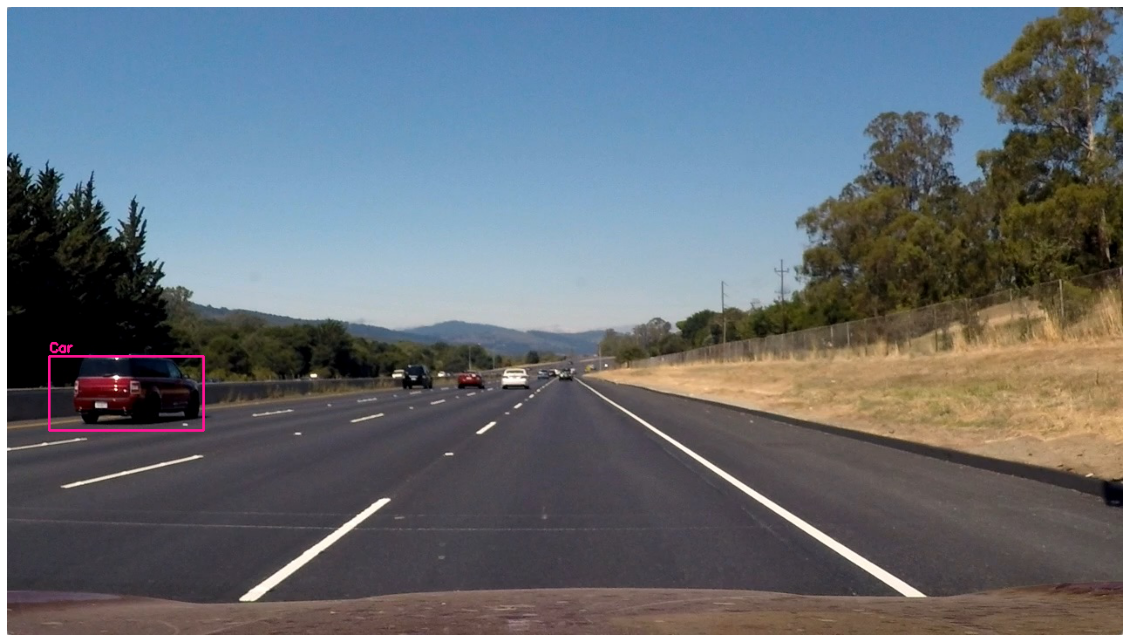

In [35]:
t = time.time()
result = process_image(test_images[2])
t2 = time.time()
print("Time taken: ", t2-t)
print("project_video_30 would take: {} minutes to finish".format(((t2-t)*751)//60))
plt.figure(figsize = (20,20))
plt.imshow(result)
plt.axis("off")


In [36]:
t = time.time()
prev_detections = PrevDetection()
project_video_res = 'project_video_result.mp4'
clip1 = VideoFileClip("/content/drive/MyDrive/Image Processing Phase 2/test_videos/project_video_30.mp4")
project_video_clip = clip1.fl_image(process_image)
project_video_clip.write_videofile(project_video_res, audio=False)
print("Time taken:{} minutes".format((time.time()-t)//60))

[MoviePy] >>>> Building video project_video_result.mp4
[MoviePy] Writing video project_video_result.mp4


100%|██████████| 751/751 [11:11<00:00,  1.12it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_result.mp4 

Time taken:11.0 minutes


### Conclusion
- HOG+SVM method took 22 minutes to render a 30 seconds video using these parameters on personal computer and 10~13 minutes on Colab.
- Further optimizations can be made on the account of accuracy.
- or using GPU Acceleration if possible.